# LangChain Expression Language (LCEL)
##### LCEL는 체인을 쉽게 구성하는 선언적 방법이다.
##### 가장 단순한 프롬프트 + LLM 체인부터 복잡한 체인까지 코드 변경 없이 프로토타입을 프로덕션에 수행할 수 있도록 설계되었다.
##### 아래에 LCEL을 사용하려는 몇 가지 이유가 있다.



*   스트리밍 지원
*   비동기 지원
*   최적화된 병렬 실행
*   재시도 및 대체
*   중간 결과에 엑세스
*   입력 및 출력 스키마
*   원활한 LangSmith 추적 통합
*   원활한 LangServe 배포 통합



# Get started
##### LCEL을 사용하여 복잡한 체인을 쉽게 구축하고 스트리밍, 병렬 처리, 로깅을 지원한다.

## 기본 예 : 프롬프트 + 모델 + 출력
##### 가장 기본적인 예제인 프롬프트 템플릿과 모델을 함께 연결하여 체인을 생성해보자.

In [ ]:
pip install --upgrade --quiet  langchain-core langchain-community langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00


In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "EXAMPLE"

In [ ]:
%pip install --upgrade --quiet  langchain-core langchain-community langchain-openai


from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 템플릿 설정
prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")
# 모델 설정
model = ChatOpenAI()
# 출력 설정
output_parser = StrOutputParser()

# 체인 생성
chain = prompt | model | output_parser

# 사용자 입력에 따른 체인 출력
chain.invoke({"topic": "ice cream"})

'Why did the ice cream break up with the hot fudge? It found out it was too vanilla for its taste!'

1. 원하는 주제에 대한 사용자 입력을 전달합니다 : {"topic" : "ice cream"}
2. 사용자 입력을 받아 프롬프트를 생성한 후 PromptValue를 생성하는데 사용된다.
3. 생성된 프롬프트를 사용하고 평가를 위해 OpenAI LLM 모델로 전달된다. 모델에서 생성된 출력은 ChatMessage 객체이다.
4. 마지막으로 호출 메서드에서 변환되는 Python 문자열로 변환한다.
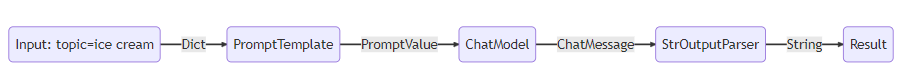

## RAG 검색
##### 질문에 응답할 때 일부 컨텍스트를 추가하기 위해 검색 증강 생성 체인을 실행한다.

In [ ]:
pip install langchain docarray tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 28.1 MB/s eta 0:00:00


In [ ]:
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

# 벡터 스토어 retriever 생성
vectorstore = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

# 프롬프트 템플릿 설정
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
# 모델 생성
model = ChatOpenAI()
# 출력 설정
output_parser = StrOutputParser()

# 사용자의 질문과 리트리버 검색기의 병렬 객체를 생성
setup_and_retrieval = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
)
# 체인 설정
chain = setup_and_retrieval | prompt | model | output_parser

# 체인에 따른 출력 설정
chain.invoke("where did harrison work?")

/usr/local/lib/python3.10/dist-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


'Harrison worked at Kensho.'

1. 첫 번째 단계에서 두 개의 항목이 있는 개체(RunnableParallel)를 만든다. 첫 번째 항목은 검색기가 가져온 문서 결과가 포함되고 두 번째 항목은 사용자의 원래 질문이 포함된다. 질문을 전달하기 위해 RunnablePassthrough를 사용하여 항목을 복사한다.
2. 사용자 입력(question, context)을 받아 프롬프트를 생성한 후 PromptValue를 생성하는데 사용된다.
3. 생성된 프롬프트를 사용하고 평가를 위해 OpenAI LLM 모델로 전달된다. 모델에서 생성된 출력은 ChatMessage 객체이다.
4. 마지막으로 호출 메서드에서 변환되는 Python 문자열로 변환한다.
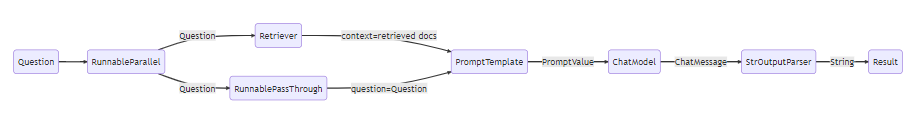

## LCEL을 사용하는 이유
##### LCEL을 사용하면 기본 구성요소로 복잡한 체인을 쉽게 구축할 수 있다.
##### 1. 통합 인터페이스 : 모든 LCEL 객체는 Runnable를 정의(invoke, batch, stream, ainvoke, ...)하는 인터페이스를 구현한다.
##### 2. 구성 기본 요소 : LCEL은 체인 구성, 구성 요소 병렬화, 폴백 추가, 체인 내부 동적 구성 등 다양한 기본 요소 제공한다.

##### LCEL 없이 유사한 기능을 만들려면 많이 노력을 해야한다.

##### 대표적으로 호출, 스트림, 배치, 비동기, 채팅, 다른 모델 사용, 런타임, 로깅, 폴백 등의 기능을 LCEL을 이용하면 편리하게 사용 가능하다.

##### 자세한 예제를 원한다면 링크(https://python.langchain.com/docs/expression_language/why) 를 클릭